ResNet中的跨层连接设计引申出了数个后续⼯作。本节我们介绍其中的⼀个：稠密连接⽹络（DenseNet）。 它与ResNet的主要区别如图5.10所示

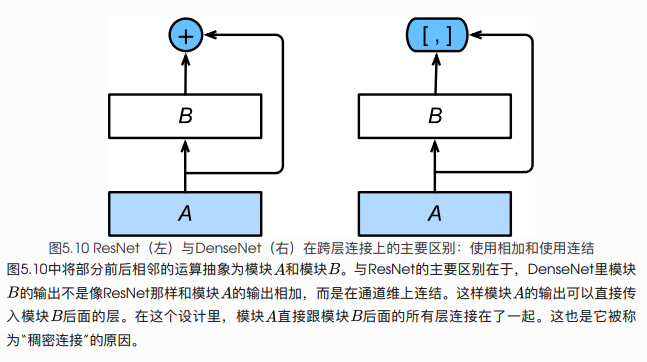

DenseNet的主要构建模块是稠密块（dense block）和过渡层（transition layer）。前者定义了输⼊和输出是如何连结的，后者则⽤来控制通道数，使之不过⼤。

# 稠密块

DenseNet使⽤了ResNet改良版的“批量归⼀化、激活和卷积”结构

In [1]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F
import sys
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def conv_block(in_channels,out_channels):
    blk=nn.Sequential(nn.BatchNorm2d(in_channels),
                     nn.ReLU(),
                     nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
    return blk

稠密块由多个 conv_block 组成，每块使⽤相同的输出通道数。但在前向计算时，我们将每块的输⼊和输出在通道维上连结

In [2]:
class DenseBlock(nn.Module):
    def __init__(self,num_convs,in_channels,out_channels):
        super(DenseBlock,self).__init__()
        net=[]
        for i in range(num_convs):
            in_c=in_channels+i*out_channels
            net.append(conv_block(in_c,out_channels))
        self.net=nn.ModuleList(net)
        self.out_channels=in_channels+num_convs*out_channels
        
    def forward(self,X):
        for blk in self.net:
            Y=blk(X)
            X=torch.cat((X,Y),dim=1) #在通道维上将输入和输出连结
        return X

In [3]:
blk=DenseBlock(2,3,10)
X=torch.rand(4,3,8,8)
Y=blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

# 过渡层

由于每个稠密块都会带来通道数的增加，使⽤过多则会带来过于复杂的模型。过渡层⽤来控制模型复杂度。它通过 卷积层来减⼩通道数，并使⽤步幅为2的平均池化层减半⾼和宽，从⽽进⼀步降低模型复杂度.

In [4]:
def transition_block(in_channels,out_channels):
    blk=nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels,out_channels,kernel_size=1),
        nn.AvgPool2d(kernel_size=2,stride=2)
    )
    return blk

In [5]:
blk=transition_block(23,10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

# DENSENET模型

我们来构造DenseNet模型。DenseNet⾸先使⽤同ResNet⼀样的单卷积层和最⼤池化层

In [6]:
net=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

类似于ResNet接下来使⽤的4个残差块，DenseNet使⽤的是4个稠密块。同ResNet⼀样，我们可以设置每个稠密块使⽤多少个卷积层。这⾥我们设成4，从⽽与上⼀节的ResNet-18保持⼀致。稠密块⾥的卷积层通道数（即增⻓率）设为32，所以每个稠密块将增加128个通道。
ResNet⾥通过步幅为2的残差块在每个模块之间减⼩⾼和宽。这⾥我们则使⽤过渡层来减半⾼和宽，并减半通道数.

In [7]:
num_channels,growth_rate=64,32  # num_channels为当前的通道数
num_convs_in_dense_blocks=[4,4,4,4]
for i,num_convs in enumerate(num_convs_in_dense_blocks):
    DB=DenseBlock(num_convs,num_channels,growth_rate)
    net.add_module('DenseBlock_%d'%i,DB)
    # 上⼀个稠密块的输出通道数
    num_channels=DB.out_channels
    # 在稠密块之间加⼊通道数减半的过渡层
    if i!=len(num_convs_in_dense_blocks)-1:
        net.add_module('transition_block_%d'%i,transition_block(num_channels,num_channels//2))
        num_channels=num_channels//2

同ResNet⼀样，最后接上全局池化层和全连接层来输出

In [8]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d,self).__init__()
    def forward(self,x):
        return F.avg_pool2d(x,kernel_size=x.size()[2:])

In [9]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

In [10]:
net.add_module('BN',nn.BatchNorm2d(num_channels))
net.add_module('relu',nn.ReLU())
net.add_module('global_avg_pool',GlobalAvgPool2d())
#GlobalAvgPool2d的输出: (Batch, num_channels, 1, 1)
net.add_module('fc',nn.Sequential(FlattenLayer(),nn.Linear(num_channels,10)))

In [11]:
X=torch.rand((1,1,96,96))
for name,layer in net.named_children():
    X=layer(X)
    print(name,'output shape:',X.shape)

0 output shape: torch.Size([1, 64, 48, 48])
1 output shape: torch.Size([1, 64, 48, 48])
2 output shape: torch.Size([1, 64, 48, 48])
3 output shape: torch.Size([1, 64, 24, 24])
DenseBlock_0 output shape: torch.Size([1, 192, 24, 24])
transition_block_0 output shape: torch.Size([1, 96, 12, 12])
DenseBlock_1 output shape: torch.Size([1, 224, 12, 12])
transition_block_1 output shape: torch.Size([1, 112, 6, 6])
DenseBlock_2 output shape: torch.Size([1, 240, 6, 6])
transition_block_2 output shape: torch.Size([1, 120, 3, 3])
DenseBlock_3 output shape: torch.Size([1, 248, 3, 3])
BN output shape: torch.Size([1, 248, 3, 3])
relu output shape: torch.Size([1, 248, 3, 3])
global_avg_pool output shape: torch.Size([1, 248, 1, 1])
fc output shape: torch.Size([1, 10])


# 获取数据并训练模型

In [12]:
import torchvision
import torchvision.transforms as transforms
def load_data_fashion_mnist(batch_size,resize=None,root='./Datasets/FashionMNIST'):
    trans=[]
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform=torchvision.transforms.Compose(trans)
    mnist_train=torchvision.datasets.FashionMNIST(root=root,train=True,download=True,transform=transform)
    mnist_test=torchvision.datasets.FashionMNIST(root=root,train=False,download=True,transform=transform)
    train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=0)
    test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=0)
    return train_iter,test_iter

batch_size=256//2
train_iter,test_iter=load_data_fashion_mnist(batch_size,resize=96)
lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)

In [14]:
def evaluate_accuracy(data_iter,net,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum,n=0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(net,torch.nn.Module):
                net.eval()#评估模式，这会关闭dropout
                acc_sum+=(net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
                net.train()#改回训练模式
            else:
                if('is_training' in net.__code__.co_varname):
                    acc_sum+=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
    return acc_sum/n

def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs):
    net=net.to(device)
    print('training on ',device)
    loss=torch.nn.CrossEntropyLoss()
    batch_count=0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y in train_iter:
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.cpu().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f,time %.lf sec'%(epoch+1,train_l_sum/batch_count,train_acc_sum/n,test_acc,time.time()-start))
        

In [15]:
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on  cuda


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 2.00 GiB total capacity; 1.04 GiB already allocated; 950.40 KiB free; 1.09 GiB reserved in total by PyTorch)